### Using a TRILEGAL file for a given healpix, produce maps with Mr - [Fe/H] priors 

Version with a subsample of the hipscat TRILEGAL catalog processed with LSDB

In [38]:
try:
    client.shutdown()
    client.close()

except Exception as e:
    print(e)
    pass

In [13]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
import glob
import os
import numpy as np
import lsdb
from lsdb.core.search import BoxSearch, ConeSearch, PolygonSearch

# import hipscat_import.pipeline as runner
# from hipscat_import.catalog.arguments import ImportArguments
# from hipscat_import.catalog.file_readers import ParquetReader
# from hipscat_import.pipeline import pipeline_with_client

cluster = SLURMCluster(
    cores=1,
    processes=1,
    memory="60GB",   # <==== barely made it!!!! increase mem
    n_workers=400,
    shebang='#!/usr/bin/env bash',
    queue="irb_slurm",
    walltime="00:30:00",
    log_directory="/mnt/beegfs/scratch/slurm_log/",
    scheduler_options={'port': 6818, 'host':'192.168.200.100', "dashboard_address": 41988}, 
    # local_directory='/mnt/beegfs/scratch/tmp',
    death_timeout="15s",
    # interface="bond0",
    # log_directory=f'{os.environ["SCRATCH_cecam"]}/{os.environ["USER"]}/dask_jobqueue_logs/',
    # project="ecam"
)

2024-12-19 11:45:18,214 - distributed.scheduler - ERROR - Task ('read_pixel-fused-nestedframe-89a65e1c9e5d86de332dbd4b292fbeca', 6220) marked as failed because 4 workers died while trying to run it
2024-12-19 12:00:50,612 - tornado.application - ERROR - Uncaught exception GET /status/ws (127.0.0.1)
HTTPServerRequest(protocol='http', host='localhost:41988', method='GET', uri='/status/ws', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/mnt/beegfs/scratch/lovro/miniforge3/envs/photod-distributed/lib/python3.12/site-packages/tornado/websocket.py", line 938, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/beegfs/scratch/lovro/miniforge3/envs/photod-distributed/lib/python3.12/site-packages/tornado/web.py", line 3301, in wrapper
    return method(self, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mn

In [14]:
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /mnt/beegfs/scratch/slurm_log//dask-worker-%J.err
#SBATCH -o /mnt/beegfs/scratch/slurm_log//dask-worker-%J.out
#SBATCH -p irb_slurm
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=56G
#SBATCH -t 00:30:00

/mnt/beegfs/scratch/lovro/miniforge3/envs/photod-distributed/bin/python -m distributed.cli.dask_worker tcp://192.168.200.100:6818 --name dummy-name --nthreads 1 --memory-limit 55.88GiB --nanny --death-timeout 15s



In [15]:
client = Client(cluster)
# cluster.scale()
# cluster.wait_for_workers(50)

In [16]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://192.168.200.100:41988/status,
Dashboard: http://192.168.200.100:41988/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://192.168.200.100:6818,Workers: 0
Dashboard: http://192.168.200.100:41988/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [17]:
cluster.dashboard_link

'http://192.168.200.100:41988/status'

In [29]:
client.dump_cluster_state

<bound method Client.dump_cluster_state of <Client: 'tcp://192.168.200.100:6818' processes=99 threads=99, memory=5.46 TiB>>

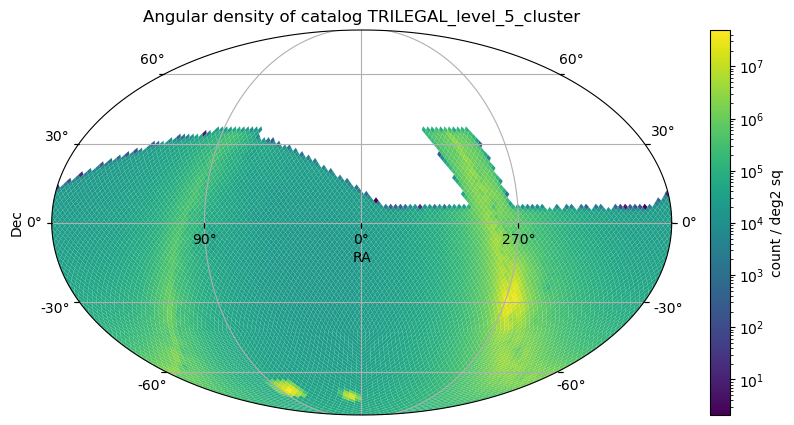

In [31]:
import hats
from hats.inspection import plot_density

catalog = hats.read_hats("/mnt/beegfs/scratch/data/TRILEGAL/TRILEGAL_hats/TRILEGAL_level_5_cluster/")
_ = plot_density(catalog, norm='log', order=5)

## Copied over from the level_6 single node (vombat) version

In [32]:
%matplotlib inline
import numpy as np
import pandas as pd
from dask.distributed import Client
pd.set_option('display.max_columns', None)

In [33]:
import os
import shutil
from collections import defaultdict

def delete_files_and_directories(directory):
    # Dictionary to store the count of each file extension
    extension_counts = defaultdict(int)
    file_count = 0
    dir_count = 0
    
    # Walk through the directory
    for root, dirs, files in os.walk(directory, topdown=False):
        # Delete files and collect their extensions
        for file in files:
            file_path = os.path.join(root, file)
            file_extension = os.path.splitext(file)[1]  # Get file extension
            extension_counts[file_extension] += 1
            os.remove(file_path)
            file_count += 1
        
        # Delete directories
        for dir in dirs:
            dir_path = os.path.join(root, dir)
            shutil.rmtree(dir_path)
            dir_count += 1
    
    # Print the results
    print(f'Total files deleted: {file_count}')
    print(f'Total directories deleted: {dir_count}')
    print('File extensions and their counts:')
    for ext, count in extension_counts.items():
        print(f'{ext}: {count}')
    
    return file_count, dir_count, dict(extension_counts)

In [34]:
%%time
import lsdb
from lsdb.core.search import BoxSearch

trilegal = lsdb.read_hats("/mnt/beegfs/scratch/data/TRILEGAL/TRILEGAL_hats/TRILEGAL_level_5_cluster") #, search_filter=BoxSearch(ra=(-53, 61), dec=(-30., 30.)))

# trilegal.skymap(lambda df, a: np.log10(len(df)+1), order=9)

CPU times: user 333 ms, sys: 36.5 ms, total: 369 ms
Wall time: 367 ms


In [35]:
%%time

from photod import priors

def prep(df, pix):
    subdir = f'{rootdir}/{str(pix.order)}'
    rootname = f'{subdir}/{str(pix.pixel)}'
    
    if not os.path.exists(subdir):
        os.makedirs(subdir)
        print(f'Directory created: {subdir}')
    else:
        print(f"Directory already exists: {subdir}")

    priors.dumpPriorMaps_testing(df, rootname, pix, verbose=False)
    return pd.DataFrame(data=[(pix, len(df))], columns=['HealPix', 'len'])

rootdir = '/mnt/beegfs/scratch/data/priors/TRILEGAL/level_5'  # TODO: clean this up!

# Perform the deletion and gather statistics
delete_files_and_directories(rootdir)
trilegal.map_partitions(prep, include_pixel=True).compute()

Total files deleted: 0
Total directories deleted: 0
File extensions and their counts:
Directory created: /mnt/beegfs/scratch/data/priors/TRILEGAL/level_5/0
sample <class 'nested_pandas.nestedframe.core.NestedFrame'>
Healpix:  Order: 0, Pixel: 0 
---------------------------------------
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no

KilledWorker: Attempted to run task ('read_pixel-fused-nestedframe-89a65e1c9e5d86de332dbd4b292fbeca', 6220) on 4 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://192.168.200.111:40113. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

In [37]:
from dask.distributed import Client
client = Client('tcp://192.168.200.111:40113')  # Connect to your scheduler

# Fetch logs for all workers
logs = client.get_worker_logs()
for worker, log in logs.items():
    print(f"Logs for {worker}:\n{log}\n")

OSError: Timed out trying to connect to tcp://192.168.200.111:40113 after 30 s